# Agglomerative Clustering (Phân cụm đa cấp)

**Mục tiêu:** Agglomerative Clustering nhằm phân nhóm các công ty thuộc chỉ số S&P 500 dựa trên đặc điểm tài chính tương đồng. Mục tiêu cuối cùng là nhận diện các nhóm doanh nghiệp có sức khỏe tài chính vững vàng, rủi ro thấp và hiệu quả sinh lời cao, hỗ trợ cho việc ra quyết định đầu tư có cơ sở định lượng.

**Nội dung notebook:**
1) Import thư viện  
2) Load dữ liệu đầu vào
3) Vẽ dendogram (cây phân cấp)
4) Chọn số cụm bằng Silhouette Score
5) Fit mô hình với số k tối ưu
6) Tính trung bình các chỉ tiêu theo cụm
7) Trực quan hóa kết quả phân cụm

## 1. Import thư viện

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram

## 2. Load dữ liệu đầu vào đã scale

In [ ]:
X = pd.read_csv('financials_features_scaled.csv')
print("Shape dữ liệu dùng để phân cụm:", X.shape)
display(X.head())

Shape dữ liệu dùng để phân cụm: (505, 15)


,price_earnings,price_book,price_sales,valuation_z__scaled,earnings_share,dividend_yield,ebitda,ebitda_log__scaled,profitability_ratio__scaled,market_cap,price,52w_range__scaled,price_to_52w_high__scaled,market_cap_log__scaled,dividend_flag__scaled
0,24.31,11.34,4.390271,0.908281,7.92,2.332862,9.048000e+09,1.102991,-0.189244,1.387211e+11,222.89,-0.229478,0.269950,1.477267,0.0
1,27.76,6.35,3.575483,0.502909,1.70,1.147959,6.010000e+08,-0.632341,-0.336064,1.078342e+10,60.24,0.083849,0.112032,-0.541755,0.0
2,22.51,3.19,3.740480,0.076988,0.26,1.908982,5.744000e+09,0.812210,-0.328124,1.021210e+11,56.27,-0.395256,0.517180,1.235165,0.0
3,19.41,26.14,6.291571,2.228956,3.29,2.499560,1.031000e+10,1.186549,-0.318950,1.813863e+11,108.48,-1.790810,2.451493,1.689222,0.0
4,25.47,10.62,2.604117,0.685735,5.44,1.714470,5.643228e+09,0.800883,-0.314349,9.876586e+10,150.51,0.011210,0.435615,1.208760,0.0


## 3. Vẽ dendrogram để xem cấu trúc phân cấp

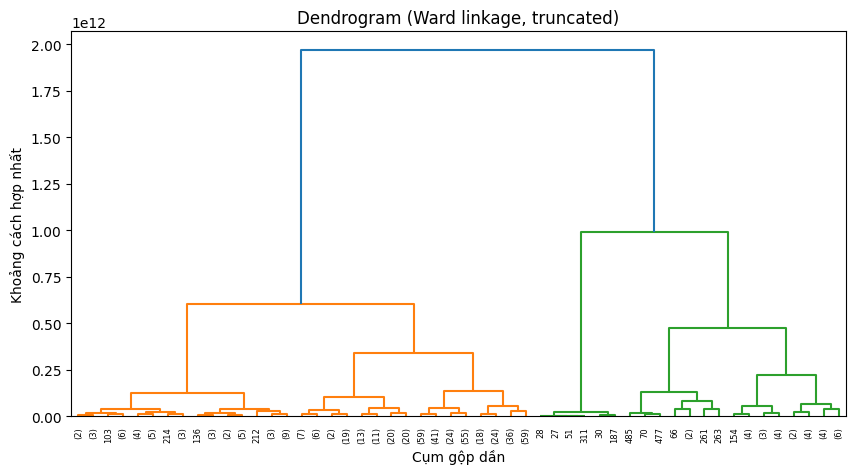

In [ ]:
Z = linkage(X, method='ward', metric='euclidean')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Dendrogram (Ward linkage, truncated)")
plt.xlabel("Cụm gộp dần")
plt.ylabel("Khoảng cách hợp nhất")
plt.show()

## 4. Chọn số cụm bằng Silhouette Score

In [ ]:
sil_scores = {}
for k in range(2, 9):
    model_temp = AgglomerativeClustering(
        n_clusters=k,
        linkage='ward',        # Ward cần metric Euclid
        metric='euclidean'
    )
    labels_temp = model_temp.fit_predict(X)
    sil = silhouette_score(X, labels_temp)
    sil_scores[k] = sil

print("Silhouette scores:", sil_scores)

best_k = max(sil_scores, key=sil_scores.get)
print("k tốt nhất theo Silhouette =", best_k, "score =", sil_scores[best_k])

Silhouette scores: {2: 0.8360249574012663, 3: 0.8238139967643011, 4: 0.6927195154497041, 5: 0.7061662103472609, 6: 0.6368153952628297, 7: 0.6396467644829157, 8: 0.5362604188159136}
k tốt nhất theo Silhouette = 2 score = 0.8360249574012663


## 5. Fit mô hình cuối cùng với k tối ưu

In [ ]:
final_model = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='ward',
    metric='euclidean'
)
cluster_labels = final_model.fit_predict(X)
X_with_cluster = X.copy()
X_with_cluster['cluster'] = cluster_labels

## 6. Tính trung bình các chỉ tiêu theo cụm để diễn giải tài chính

In [ ]:
cluster_profile = X_with_cluster.groupby('cluster').mean()

print("Đặc trưng trung bình theo cụm:")
display(cluster_profile)

Đặc trưng trung bình theo cụm:


,price_earnings,price_book,price_sales,valuation_z__scaled,earnings_share,dividend_yield,ebitda,ebitda_log__scaled,profitability_ratio__scaled,market_cap,price,52w_range__scaled,price_to_52w_high__scaled,market_cap_log__scaled,dividend_flag__scaled
cluster,,,,,,,,,,,,,,,
0,27.279505,20.633857,4.676162,1.835771,5.236429,2.279467,1.625230e+10,-0.670017,-0.144607,2.526037e+11,143.491324,0.000236,0.200964,1.870879,-0.119048
1,23.908528,8.585189,3.863049,0.599849,3.603220,1.841043,2.276852e+09,-1.718971,0.189843,2.850642e+10,94.004714,-0.112864,0.104328,-0.012522,-0.174946


## 7. Trực quan hóa kết quả phân cụm

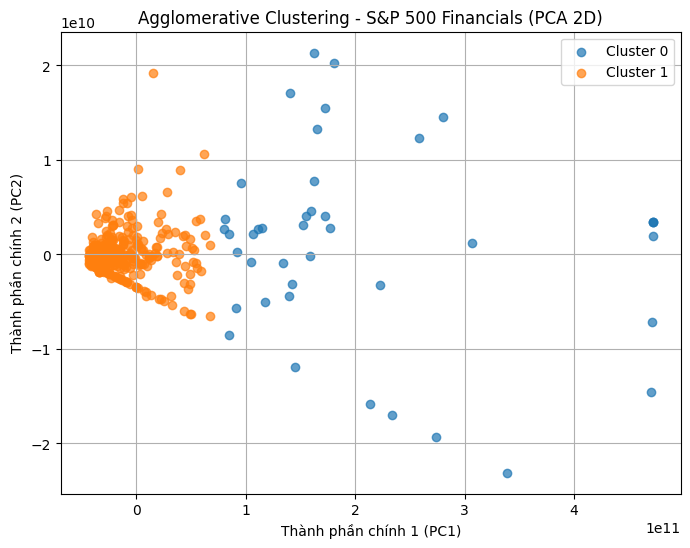

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': cluster_labels
})
plt.figure(figsize=(8, 6))
for c in plot_df['cluster'].unique():
    plt.scatter(
        plot_df.loc[plot_df['cluster'] == c, 'PC1'],
        plot_df.loc[plot_df['cluster'] == c, 'PC2'],
        label=f'Cluster {c}',
        alpha=0.7
    )

plt.title('Agglomerative Clustering - S&P 500 Financials (PCA 2D)')
plt.xlabel('Thành phần chính 1 (PC1)')
plt.ylabel('Thành phần chính 2 (PC2)')
plt.legend()
plt.grid(True)
plt.show()